In [1]:
import cffi
import numpy as np
from pynq import MMIO
from pynq import Overlay
from pynq import PL
from pynq.drivers import DMA
from time import sleep, time

# Classifier Dimensions
BATCH = 8192
FEAT = 64
CLASSES = 10

# Addresses
ACCEL_CTRL = 0x43C00000
AXI_DMA_0 = 0x40400000
AXI_DMA_1 = 0x40410000
AXI_TIMER = 0x42800000

# C FFI
ffi = cffi.FFI()

# DMA Configs
DMAConfig1 = {
    'DeviceId' : 0,
    'BaseAddr' : ffi.cast("uint32_t *",AXI_DMA_0),
    'HasStsCntrlStrm' : 0,
    'HasMm2S' : 1,
    'HasMm2SDRE' : 1,
    'Mm2SDataWidth' : 64,
    'HasS2Mm' : 0,
    'HasS2MmDRE' : 0,
    'S2MmDataWidth' : 32,
    'HasSg' : 0,
    'Mm2sNumChannels' : 1,
    'S2MmNumChannels' : 1,
    'Mm2SBurstSize' : 256,
    'S2MmBurstSize' : 16,
    'MicroDmaMode' : 0,
    'AddrWidth' : 32
}
DMAConfig2 = {
    'DeviceId' : 1,
    'BaseAddr' : ffi.cast("uint32_t *",AXI_DMA_1),
    'HasStsCntrlStrm' : 0,
    'HasMm2S' : 0,
    'HasMm2SDRE' : 0,
    'Mm2SDataWidth' : 32,
    'HasS2Mm' : 1,
    'HasS2MmDRE' : 1,
    'S2MmDataWidth' : 64,
    'HasSg' : 0,
    'Mm2sNumChannels' : 1,
    'S2MmNumChannels' : 1,
    'Mm2SBurstSize' : 16,
    'S2MmBurstSize' : 256,
    'MicroDmaMode' : 0,
    'AddrWidth' : 32
}

# Download the custom overlay
ol = Overlay("classifier_fixed.bit")
ol.download()

# Initialize HLS IP
mmult_ip = MMIO(ACCEL_CTRL,0x10000)
# Start the accelerator
ctrl=mmult_ip.read(0x00)&0x08
mmult_ip.write(0x00, (ctrl|0x81))
ctrl=mmult_ip.read(0x00)
hex(ctrl)

# Initialize DMA1 (mem to FPGA)
dma1 = DMA(AXI_DMA_0, direction=0, attr_dict=DMAConfig1)
dma1.create_buf((CLASSES*4+CLASSES*FEAT+BATCH*FEAT), cacheable=0)

# Initialize DMA2 (FPGA to mem)
dma2 = DMA(AXI_DMA_1, direction=1, attr_dict=DMAConfig2)
dma2.create_buf(BATCH*CLASSES*4, cacheable=0)
# Start DMA transfer from FPGA to memory
dma2.transfer(BATCH*CLASSES*4, direction=1)

In [2]:
# Initialize offsets, weights and inputs
o = np.load('model_offsets_fixed.npy').astype(np.int32)
w = np.load('model_weights_fixed.npy').astype(np.int8)
i = np.load('test_data.npy').astype(np.uint8)[0:BATCH]
l = np.load('test_labels.npy').astype(np.int32)[0:BATCH]

print("{}\n{}\n{}\n{}".format(o.shape, w.shape, i.shape, l.shape))

(10,)
(10, 64)
(8192, 64)
(8192,)


In [3]:
# Move offset, weight and input data to DMA buffer
ffi.memmove(dma1.get_buf(), ffi.cast("uint32_t *", o.ctypes.data), CLASSES*4)
ffi.memmove(dma1.get_buf()+CLASSES, ffi.cast("uint32_t *", w.ctypes.data), CLASSES*FEAT)
ffi.memmove(dma1.get_buf()+CLASSES+(CLASSES*FEAT)//4, ffi.cast("uint32_t *", i.ctypes.data), BATCH*FEAT)

# Perform FPGA offloading
start_t = time()
dma1.transfer(CLASSES*4+CLASSES*FEAT+BATCH*FEAT, direction=0)
dma2.wait()
fpga_time = time()-start_t

# Dump FPGA result to a numpy array
c = np.frombuffer(ffi.buffer(
        dma2.get_buf(),BATCH*CLASSES*4),
        dtype=np.int32).reshape(BATCH,CLASSES)

In [4]:
# Prepare input and weight matrices for matrix multiplication on CPU
ones = np.ones(BATCH).reshape((BATCH,1))
i_p = np.append(ones, i, axis=1)
w_p = np.append(o.reshape(CLASSES,1), w, axis=1)

# Compute CPU result
start_t = time()
c_ref = np.dot(i_p,w_p.T)
cpu_time = time()-start_t

In [5]:
# Evaluate validation accuracy
cpu_errors = 0
fpga_errors = 0
for idx in range(BATCH):
    fpga_label = np.argmax(c[idx])
    cpu_label = np.argmax(c_ref[idx])
    actual_label = l[idx] # np.argmax(l[idx])
    if (fpga_label!=actual_label):
        fpga_errors += 1.
    if (cpu_label!=actual_label):
        cpu_errors += 1.

# Report results
print("FPGA accuracy: {0:.2f}% validation error".format(fpga_errors/BATCH*100))
print("CPU accuracy:  {0:.2f}% validation error".format(cpu_errors/BATCH*100))
print("FPGA time: {}".format(fpga_time))
if (cpu_time < fpga_time):
    print("FPGA has a {0:.2f}x slowdown".format(fpga_time/cpu_time))
else:
    print("FPGA has a {0:.2f}x speedup".format(cpu_time/fpga_time))

FPGA accuracy: 12.99% validation error
CPU accuracy:  12.99% validation error
FPGA time: 0.003409587000078318
FPGA has a 21.84x speedup


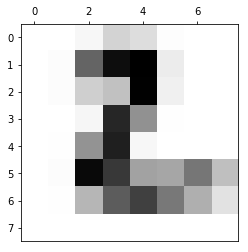

Classified as 2 by the FPGA


In [6]:
# Render a given numpy 2D array of pixel data.
def show(image):
    from matplotlib import pyplot
    import matplotlib as mpl
    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    pyplot.show()

# Inspect one of the hand digits classified by the FPGA
idx = 1
show(i[idx].reshape(8,8))
print("Classified as {} by the FPGA".format(np.argmax(c[idx])))